# Úkol č. 3 - Segmentace zákazníků e-shopu (do 29. listopadu)

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
    - Počet dnů počítejte ke dni uskutečnění poslendní transakce v celém datasetu (tj. 12/19/2015), nikoli k dnešku. Tváříme se, že jde o aktuální data.
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu:

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv
from ipyvolume import pylab
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("eshop.csv")

In [3]:
df.head()

,Customer ID,Date,Subtotal,Country
0,34,6/21/2007,86.0,Czech Republic
1,38,6/27/2007,38.4,Czech Republic
2,47,7/2/2007,53.5,Slovakia
3,61,7/14/2007,7.0,Czech Republic
4,78,7/21/2007,55.5,Czech Republic


## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Ke komentování toho, co v notebooku děláte, použijte Markdown buňky.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni


## Příprava data frame

In [4]:
orfm = df.copy()
orfm["Date"] = pd.to_datetime(orfm["Date"])
orfm["recency"] = orfm["Date"].max() - orfm["Date"]
orfm["frequency"] = 1

# rename columns
orfm["id"] = orfm["Customer ID"]
orfm["monetary"] = orfm["Subtotal"]
del orfm["Customer ID"]
del orfm["Subtotal"]

rfm = orfm.groupby(["id"]).agg({"recency": "min", "frequency": "sum", "monetary": "sum"})
rfm["recency"] = rfm["recency"].dt.days
display(rfm.head())
display("pocty nevalidnich hodnot")
rfm.isnull().sum()

,recency,frequency,monetary
id,,,
7,311,3,15.54
9,3050,1,13.20
30,3025,1,36.20
34,3103,1,86.00
38,3097,1,38.40


'pocty nevalidnich hodnot'

recency      0
frequency    0
monetary     0
dtype: int64

## Shlukování

In [5]:
def plot_3d_scatter(title, df, colours):
    f = plt.figure(figsize=(8,6), dpi=100).gca(projection = "3d")
    plt.title(title)
    f.invert_xaxis()
    f.scatter(df.recency, df.frequency, df.monetary, c = colours)
    f.set_xlabel('recency')
    f.set_ylabel('frequency')
    f.set_zlabel('monetary')

def plot_kmeans(df):
    result = []
    for n in range(2, 10):
        kmeans = KMeans(n).fit(df)
        prediction = kmeans.predict(df)
        result.append(prediction)
        plot_3d_scatter("k-means pro k = " + str(n), df, prediction)
    return result

[array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([2, 1, 1, ..., 2, 2, 2], dtype=int32),
 array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([2, 0, 0, ..., 2, 2, 2], dtype=int32),
 array([0, 1, 1, ..., 0, 0, 0], dtype=int32),
 array([6, 0, 0, ..., 6, 6, 6], dtype=int32),
 array([2, 5, 5, ..., 2, 2, 2], dtype=int32)]

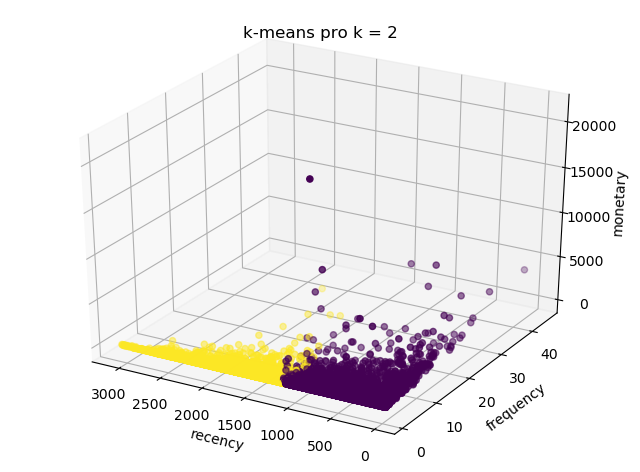

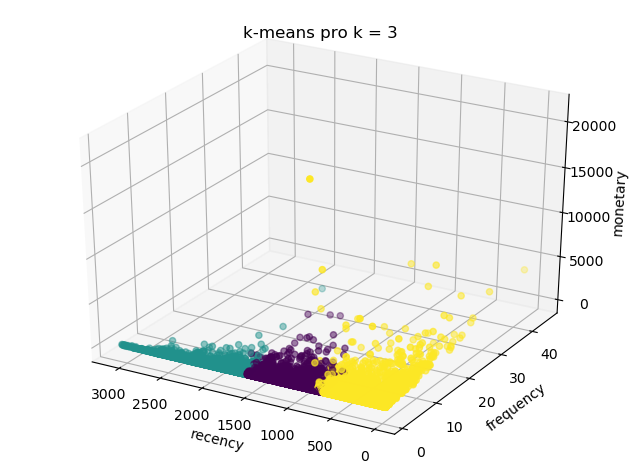

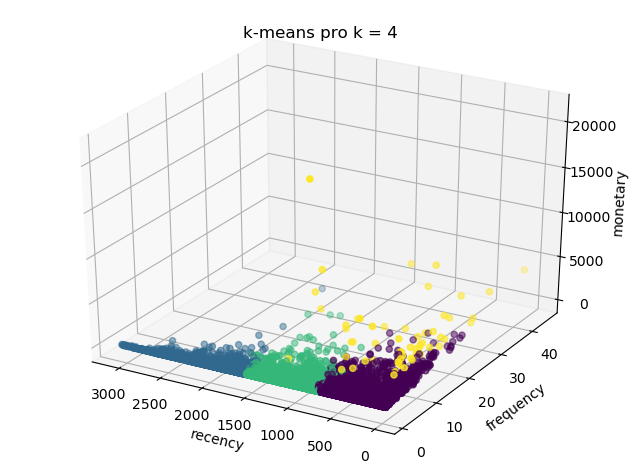

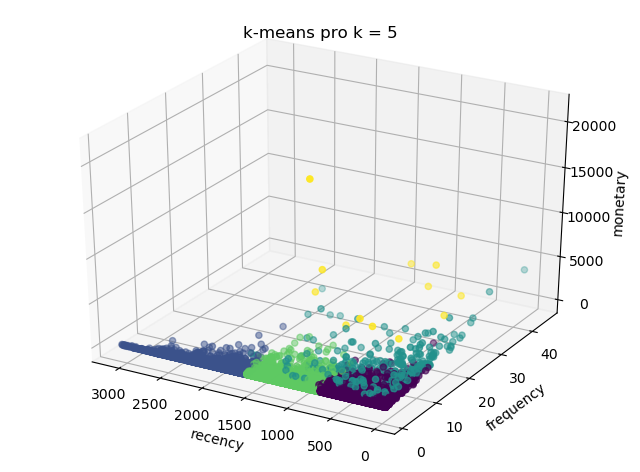

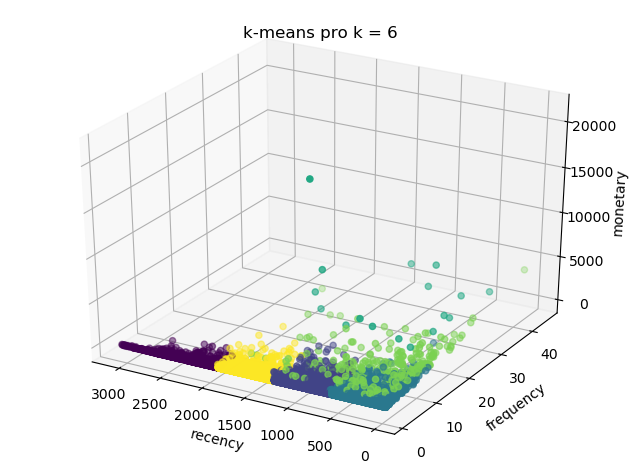

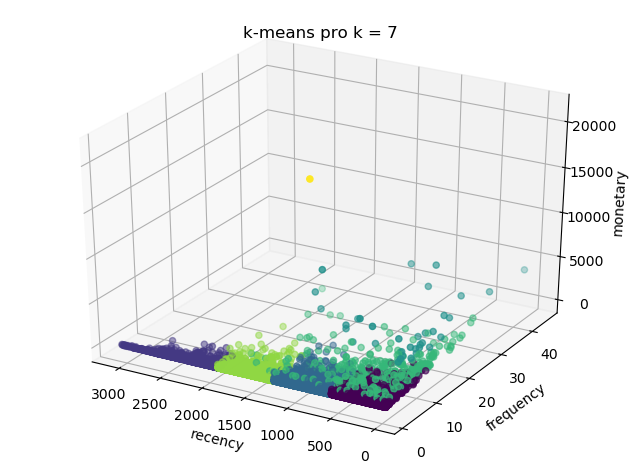

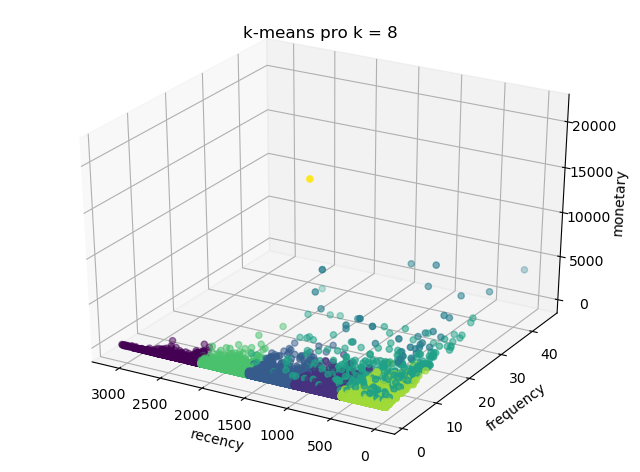

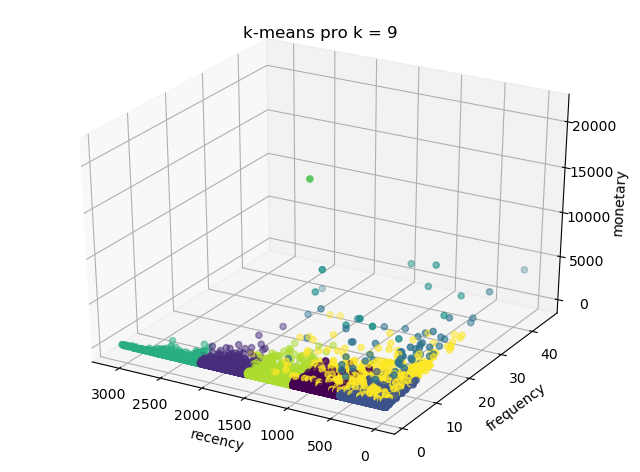

In [6]:
plot_kmeans(rfm)

`monetary` by to očividně chtělo přeškálovat; zákazníci jsou na této ose rozděleni logaritmicky. Rozhodnutí o nejlepším počtu shluků tedy prozatím odložím.

Použiji logaritmus o bázi 1.2 - čím blíže k 1, tím lépe rozliší k-means mezi extrémy na příslušné ose, ale tím dál budou v původních datech logaritmicky rozdělené hodnoty od rovnoměrného rozdělení po transformaci.

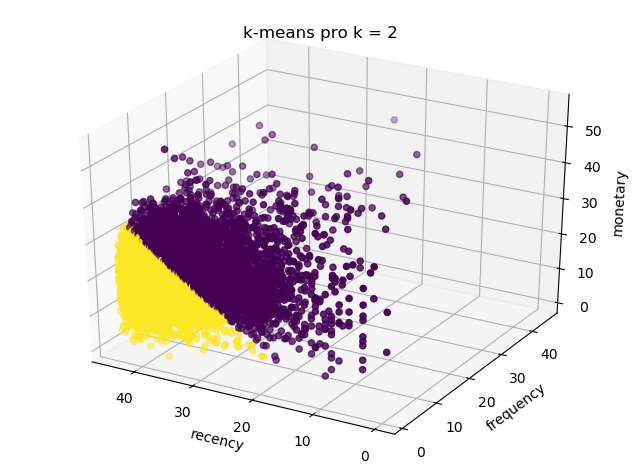

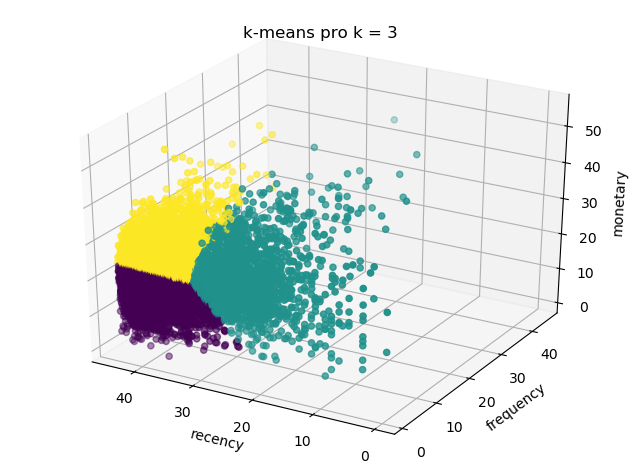

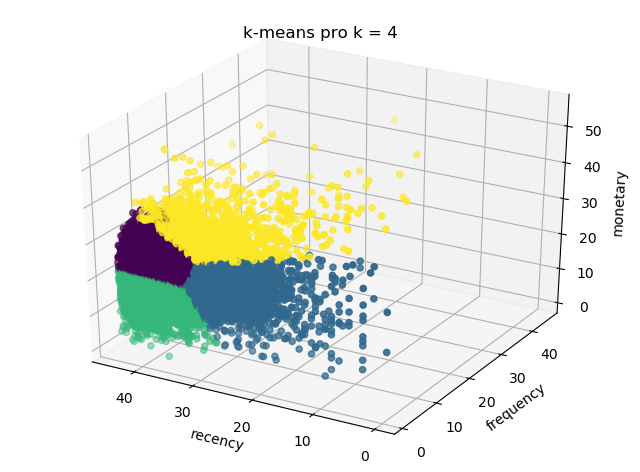

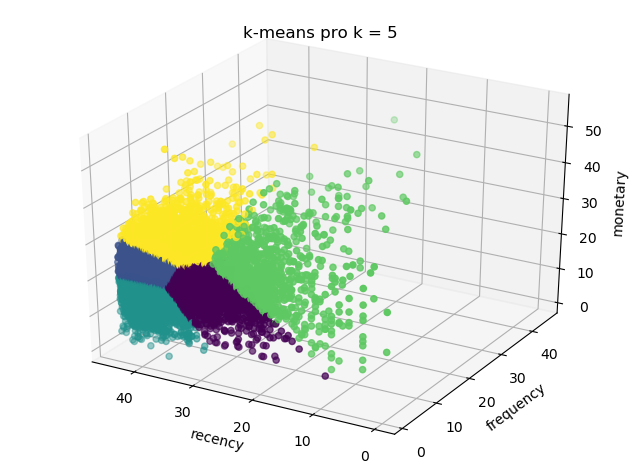

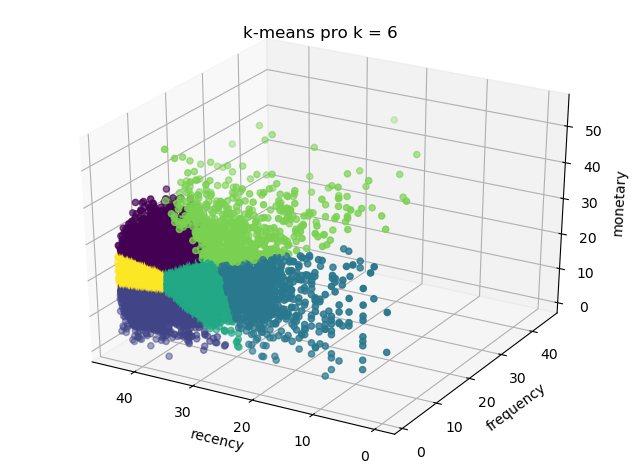

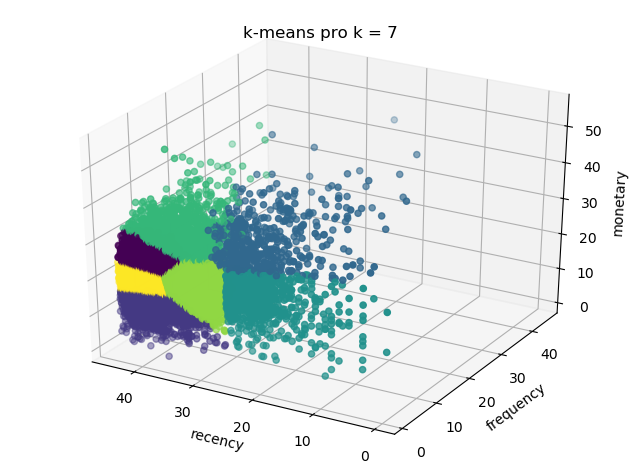

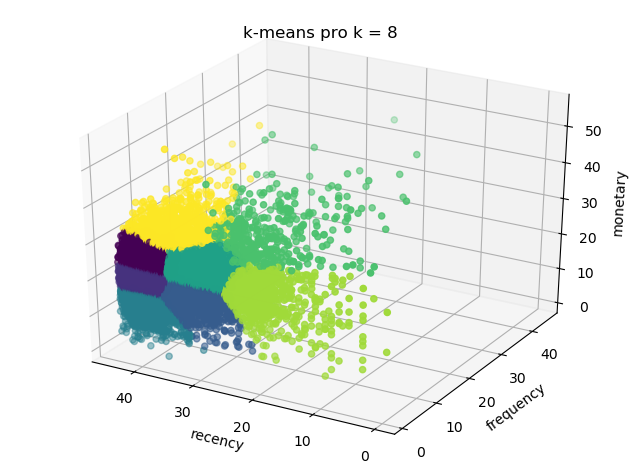

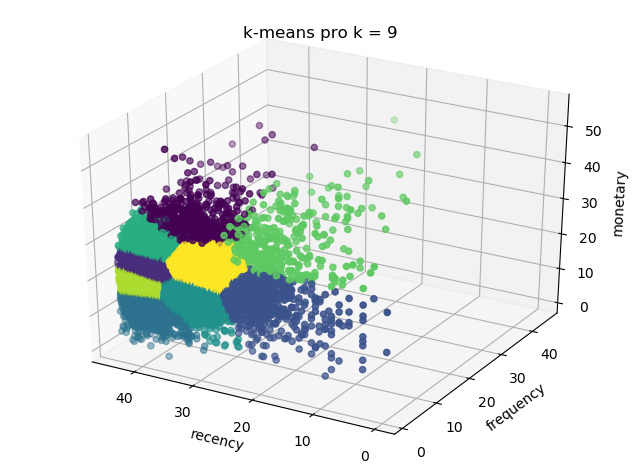

In [7]:
srfm = rfm.copy()
# srfm.frequency = np.log(srfm.frequency) / np.log(1.2)
srfm.monetary  = np.log(srfm.monetary)  / np.log(1.2)
srfm.recency   = np.log1p(srfm.recency) / np.log(1.2)
scaled_predictions = plot_kmeans(srfm)

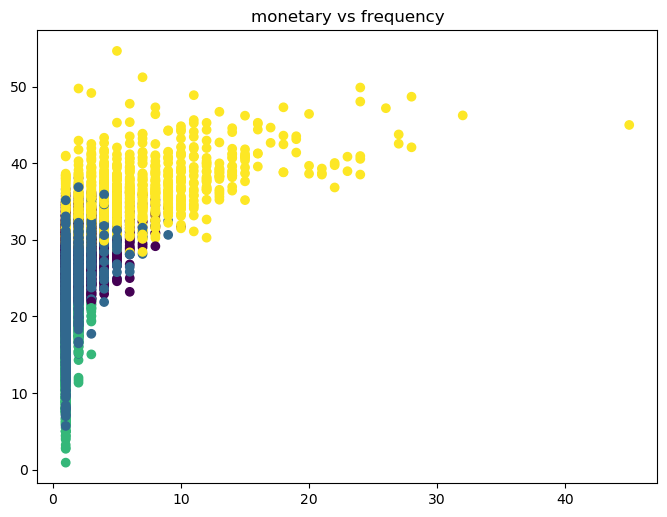

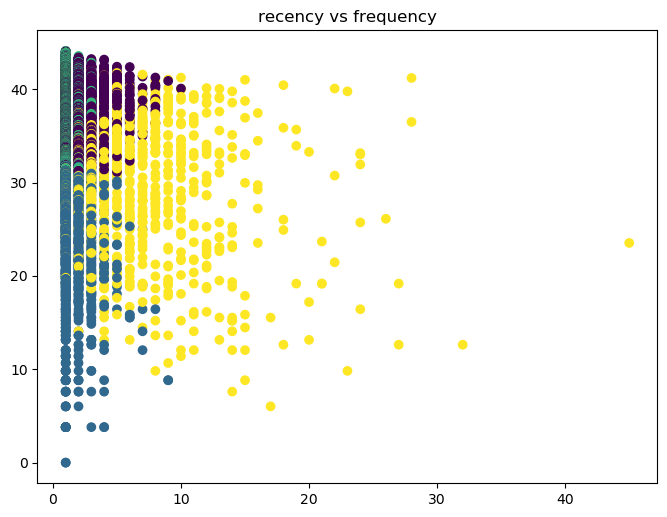

In [8]:
prediction = scaled_predictions[4 - 2]

f = plt.figure(figsize=(8,6), dpi=100)
plt.title("monetary vs frequency")
plt.scatter(srfm.frequency, srfm.monetary, c = prediction)

f = plt.figure(figsize=(8,6), dpi=100)
plt.title("recency vs frequency")
plt.scatter(srfm.frequency, srfm.recency, c = prediction)

In [14]:
df = srfm
prediction = scaled_predictions[4 - 2]
colours = np.array([[242, 219, 42], [0, 54, 114], [110, 1, 137], [2, 211, 89]]) / 255

display(df.head(), prediction, colours)

f = pylab.figure()
pylab.style.use("dark")
pylab.xlabel("recency")
pylab.ylabel("frequency")
pylab.zlabel("monetary")
pylab.scatter(
    df.recency.array, df.frequency.array + 0.0, df.monetary.array,
    color = colours[prediction],
    size = 15,
    marker = "point_2d"
)
f

,recency,frequency,monetary
id,,,
7,31.499310,3,15.047136
9,44.005903,1,14.152012
30,43.960775,1,19.685325
34,44.100363,1,24.431271
38,44.089751,1,20.008920


array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

array([[0.94901961, 0.85882353, 0.16470588],
       [0.        , 0.21176471, 0.44705882],
       [0.43137255, 0.00392157, 0.5372549 ],
       [0.00784314, 0.82745098, 0.34901961]])

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…